In [17]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from pathlib import Path

import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

import utils.training as train_utils; imp.reload(train_utils)
#import utils.plot as plot_utils; imp.reload(plot_utils)

import camvid_dataset as camvid
import joint_transforms
%matplotlib inline

/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [18]:
from data import CityscapesDataset, num_classes, full_to_colour, train_to_full
from model import FeatureResNet, SegResNet

In [19]:
# setup
if not os.path.exists('cityscapes_results'):
    os.makedirs('cityscapes_results')

In [32]:
# hyperparmas:
seed = 42
workers = 8
epochs = 2  # 100
crop_size = 512
lr = 5e-5
weight_decay = 2e-4
batch_size = 1 # 2

In [33]:
torch.manual_seed(seed)

In [34]:
# input data for cityscapes dataset
train_dataset = CityscapesDataset(split='train', crop=crop_size, flip=True)
val_dataset = CityscapesDataset(split='val')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=workers, pin_memory=True)

In [35]:
len(train_loader)

2975

In [36]:
len(val_loader)

500

### perform resnet-cn for cityscapes dataset, randomly crop the 2048x1024 input into 512x512 as input of the nn, the segmentation output is 20x512x512 for 20 categories.

In [40]:
for i, (input, target, _) in enumerate(train_loader):  
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Process Process-16:
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/weakref.py", line 108, in remove
Process Process-14:
Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7fb38fbe37b8>
Process Process-13:
Process Process-10:
Process Process-9:
Process Process-12:
Traceback (most recent call last):
Process Process-11:
    def remove(wr, selfref=ref(self)):
KeyboardInterrupt
Traceback (most recent call last):
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])


KeyboardInterrupt: 

  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 41, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/code/mil_pytorch_tiramisu/data.py", line 62, in __getitem__
    target[c][remapped_target == c] = 1
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/tf1.0_gpu/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/tf1.0_g

In [41]:
type(input)

torch.FloatTensor

In [43]:
input.size()

torch.Size([1, 3, 512, 512])

In [42]:
type(target)

torch.FloatTensor

In [44]:
target.size()

torch.Size([1, 20, 512, 512])

In [46]:
input_img=input[0].numpy().transpose((1, 2, 0))

In [50]:
input_img=input[0].numpy().transpose((1, 2, 0))
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [51]:
ori_input_img = input_img*std+mean

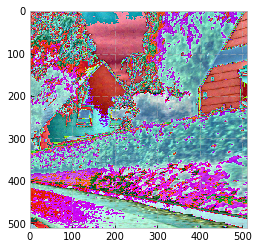

In [48]:
plt.imshow(input_img)

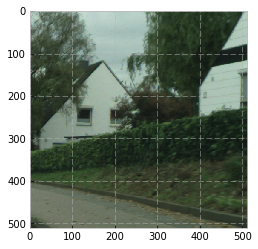

In [52]:
plt.imshow(ori_input_img)

### Concat function

In [ ]:
# stack gt with rgb
input_concat = torch.cat([input, target], 1)

In [55]:
input_concat.size()

torch.Size([1, 23, 512, 512])

In [62]:
tmp_img = input_concat[0,0:3]

In [63]:
type(tmp_img)

torch.FloatTensor

In [64]:
input_tmp_img=tmp_img.numpy().transpose((1, 2, 0))
ori_input_tmp_img = input_tmp_img*std+mean

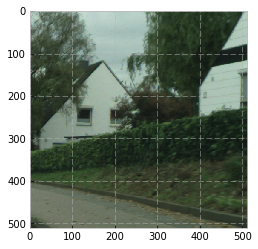

In [66]:
plt.imshow(ori_input_tmp_img)

In [ ]:
import torch
from torch import nn
from torch.nn import init
from torchvision.models.resnet import BasicBlock, ResNet


# Returns 2D convolutional layer with space-preserving padding
def conv(in_planes, out_planes, kernel_size=3, stride=1, dilation=1, bias=False, transposed=False):
    if transposed:
        layer = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1, dilation=dilation, bias=bias)
        # Bilinear interpolation init
        w = torch.Tensor(kernel_size, kernel_size)
        centre = kernel_size % 2 == 1 and stride - 1 or stride - 0.5
        for y in range(kernel_size):
            for x in range(kernel_size):
                w[y, x] = (1 - abs((x - centre) / stride)) * (1 - abs((y - centre) / stride))
        layer.weight.data.copy_(w.div(in_planes).repeat(out_planes, in_planes, 1, 1))
    else:
        padding = (kernel_size + 2 * (dilation - 1)) // 2
        layer = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias)
    if bias:
        init.constant(layer.bias, 0)
    return layer


# Returns 2D batch normalisation layer
def bn(planes):
    layer = nn.BatchNorm2d(planes)
    # Use mean 0, standard deviation 1 init
    init.constant(layer.weight, 1)
    init.constant(layer.bias, 0)
    return layer


class FeatureResNet(ResNet):
    def __init__(self):
        # as use BasicBlock, it it ResNet-34
        super().__init__(BasicBlock, [3, 4, 6, 3], 1000)
        # as use Bottleneck, it it ResNet-50
        #super().__init__(Bottleneck, [3, 4, 6, 3], 1000)
        
  
    def forward(self, x):
        x1 = self.conv1(x)
        x = self.bn1(x1)
        x = self.relu(x)
        x2 = self.maxpool(x)
        x = self.layer1(x2)
        x3 = self.layer2(x)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x1, x2, x3, x4, x5


class SegResNet(nn.Module):
    def __init__(self, num_classes, pretrained_net):
        super().__init__()
        self.pretrained_net = pretrained_net
        self.relu = nn.ReLU(inplace=True)
        self.conv5 = conv(512, 256, stride=2, transposed=True)
        self.bn5 = bn(256)
        self.conv6 = conv(256, 128, stride=2, transposed=True)
        self.bn6 = bn(128)
        self.conv7 = conv(128, 64, stride=2, transposed=True)
        self.bn7 = bn(64)
        self.conv8 = conv(64, 64, stride=2, transposed=True)
        self.bn8 = bn(64)
        self.conv9 = conv(64, 32, stride=2, transposed=True)
        self.bn9 = bn(32)
        self.conv10 = conv(32, num_classes, kernel_size=7)
        init.constant(self.conv10.weight, 0)  # Zero init
  
    def forward(self, x):
        x1, x2, x3, x4, x5 = self.pretrained_net(x)
        x = self.relu(self.bn5(self.conv5(x5)))
        x = self.relu(self.bn6(self.conv6(x + x4)))
        x = self.relu(self.bn7(self.conv7(x + x3)))
        x = self.relu(self.bn8(self.conv8(x + x2)))
        x = self.relu(self.bn9(self.conv9(x + x1)))
        x = self.conv10(x)
        return x


### Define the network

In [68]:
pretrained_net = FeatureResNet()

In [37]:
# traing steps
# e = epoch
def train(e):
    # only useful for dropout / batchnorm
    net.train()
    #  loop over the data iterator, and feed the inputs to the network and optimize
    for i, (input, target, _) in enumerate(train_loader):
        # reset grad
        optimiser.zero_grad()
        # use GPU CUDA
        input, target = Variable(input.cuda(async=True)), Variable(target.cuda(async=True))
        
        # why use sigmoid function?
        output = F.sigmoid(net(input))
        loss = crit(output, target)
        print(e, i, loss.data[0])
        # compute gradients
        loss.backward()
        # update params with gradients
        optimiser.step()

TypeError: 'DataLoader' object is not subscriptable

In [11]:
for i, (input, target, _) in enumerate(train_loader):
    # reset grad
    optimiser.zero_grad()
    # use GPU CUDA
    input, target = Variable(input.cuda(async=True)), Variable(target.cuda(async=True))
    
    # why use sigmoid function?
    output = F.sigmoid(net(input))
    loss = crit(output, target)
    print(e, i, loss.data[0])
    # compute gradients
    loss.backward()
    # update params with gradients
    optimiser.step()

[]

In [2]:
DATA_PATH='/data/code/SegNet-Tutorial/'
RESULTS_PATH='results/'
WEIGHTS_PATH='models/'
CAMVID_PATH=DATA_PATH+'CamVid/'
EXPERIMENT='tiramisu'

In [3]:
def center_crop(layer, max_height, max_width):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/merge.py#L162
    #Author does a center crop which crops both inputs (skip and upsample) to size of minimum dimension on both w/h
    batch_size, n_channels, layer_height, layer_width = layer.size()
    xy1 = (layer_width - max_width) // 2
    xy2 = (layer_height - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]

In [4]:
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        
        #author's impl - lasange 'same' pads with half 
        # filter size (rounded down) on "both" sides
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                out_channels=growth_rate, kernel_size=3, stride=1, 
                  padding=1, bias=True))
        
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super(DenseLayer, self).forward(x)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super(DenseBlock, self).__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])
        
    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x 
    
class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super(TransitionDown, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
              out_channels=in_channels, kernel_size=1, stride=1, 
                padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))
        
    def forward(self, x):
        return super(TransitionDown, self).forward(x)
    
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
               out_channels=out_channels, kernel_size=3, stride=2, 
              padding=0, bias=True) #crop = 'valid' means padding=0. Padding has reverse effect for transpose conv (reduces output size)
        #http://lasagne.readthedocs.io/en/latest/modules/layers/conv.html#lasagne.layers.TransposedConv2DLayer
        #self.updample2d = nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out
    
class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(Bottleneck, self).__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super(Bottleneck, self).forward(x)

### Model

In [5]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5), 
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super(FCDenseNet, self).__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        
        cur_channels_count = 0
        skip_connection_channel_counts = []
        
        
        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_chans_first_conv, kernel_size=3, 
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv
        
        
        
        #####################
        # Downsampling path #
        #####################
        
        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))
            
            
            
        #####################
        #     Bottleneck    #
        #####################
        
        self.add_module('bottleneck',Bottleneck(cur_channels_count, 
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels 
        
        
        
        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i], 
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

            
        #One final dense block
        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1], 
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        
        
        #####################
        #      Softmax      #
        #####################

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count, 
               out_channels=n_classes, kernel_size=1, stride=1, 
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        #print("INPUT",x.size())
        out = self.firstconv(x)
        
        skip_connections = []
        for i in range(len(self.down_blocks)):
            #print("DBD size",out.size())
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            
        out = self.bottleneck(out)
        #print ("bnecksize",out.size())
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            #print("DOWN_SKIP_PRE_UPSAMPLE",out.size(),skip.size())
            out = self.transUpBlocks[i](out, skip)
            #print("DOWN_SKIP_AFT_UPSAMPLE",out.size(),skip.size())
            out = self.denseBlocksUp[i](out)
            
        out = self.finalConv(out)
        out = self.softmax(out)
        return out
    
def FCDenseNet57(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4, 4, 4, 4, 4), 
                 up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4, 
                 growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet67(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(5, 5, 5, 5, 5), 
                 up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet103(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4,5,7,10,12), 
                 up_blocks=(12,10,7,5,4), bottleneck_layers=15, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

**CamVid dataset**

* TrainingSet = 367 frames
* ValidationSet = 101 frames
* TestSet = 233 frames
* Images of resolution 360x480
* Images "Cropped" to 224x224 for training --- center crop?
* FullRes images used for finetuning
* NumberOfClasses = 11 (output), total classes = 12 (with unlabel)
* BatchSize = 3  (set to 1 due to GPU memory limits)

In [6]:
batch_size = 1 #2
seed = 0
torch.cuda.manual_seed(seed)

In [7]:
traindir = os.path.join(CAMVID_PATH, 'train')
valdir = os.path.join(CAMVID_PATH, 'val')
testdir = os.path.join(CAMVID_PATH, 'test')

In [8]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)

In [9]:
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224),
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

In [15]:
??joint_transforms

In [18]:
print(train_loader.dataset.classes)

['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrain', 'Bicyclist', 'Void']


In [19]:
print(train_loader.dataset.class_weight)


 0.5887
 0.5105
 2.6966
 0.4502
 1.1785
 0.7703
 2.4783
 2.5273
 1.0123
 3.2375
 4.1312
 0.0000
[torch.FloatTensor of size 12]



In [20]:
print(train_loader.dataset.imgs[:3])

['/data/code/SegNet-Tutorial/CamVid/train/0006R0_f01950.png', '/data/code/SegNet-Tutorial/CamVid/train/0001TP_007560.png', '/data/code/SegNet-Tutorial/CamVid/train/0016E5_05070.png']


In [21]:
print(train_loader.dataset.mean)
print(train_loader.dataset.std)

[0.41189489566336, 0.4251328133025, 0.4326707089857]
[0.27413549931506, 0.28506257482912, 0.28284674400252]


In [10]:
print("TrainImages: %d" %len(train_loader.dataset.imgs))
print("ValImages: %d" %len(val_loader.dataset.imgs))
print("TestImages: %d" %len(test_loader.dataset.imgs))
print("NumClasses: %d" % len(train_loader.dataset.classes))

example_inputs, example_targets = next(iter(train_loader))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

#Inputs are tensors of normalized pixel values
print ("\nInput (size, max, min) ---")
i = example_inputs[0]
print (i.size())
print(i.max())
print(i.min())


#Targets are tensors of class labels from 0-11 (0 means background)
print ("Target (size, max, min) ---")
t = example_targets[0]
print(t.size())
print(t.max())
print(t.min())

TrainImages: 367
ValImages: 101
TestImages: 233
NumClasses: 12
InputsBatchSize:  torch.Size([1, 3, 360, 480])
TargetsBatchSize:  torch.Size([1, 360, 480])

Input (size, max, min) ---
torch.Size([3, 360, 480])
2.145308017730713
-1.5297001600265503
Target (size, max, min) ---
torch.Size([360, 480])
11
0


## Visualize

* https://discuss.pytorch.org/t/convert-pixel-wise-class-tensor-to-image-segmentation/1268
* http://www.colorspire.com/rgb-color-wheel/ (verify RGB colors)

In [11]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
      Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(camvid.mean)
    std = np.array(camvid.std)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    """Imshow for Tensor."""
    inp = decode_image(tensor)
    plt.imshow(inp)
    plt.show()

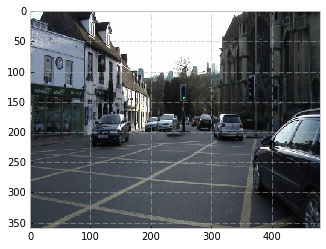

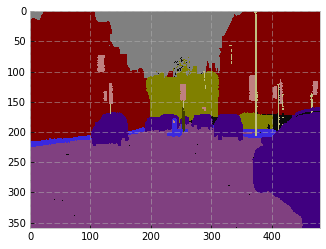

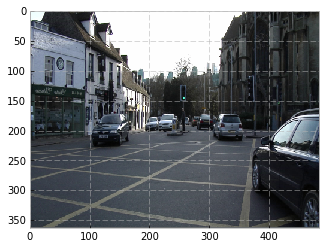

In [12]:
# Get a batch of training data
inputs, targets = next(iter(train_loader))
#inputs, targets = next(iter(val_loader))
#inputs, targets = next(iter(test_loader))

# Plot Single Image
view_image(inputs[0])

# Plot Target Image
view_annotated(targets[0])

# Plot Grid of images
out = torchvision.utils.make_grid(inputs, nrow=3)
view_image(out)

## Visdom web browser

* https://github.com/facebookresearch/visdom
* https://github.com/facebookresearch/visdom/blob/master/example/demo.py

In [13]:
visdom_enabled = True
import visdom
viz = visdom.Visdom()

In [14]:
def viz_plot_train_test(window, epoch, train_val, test_val, name='loss', env='main'):
    if window is None:
        return viz.line(
            X=np.array([epoch]),
            Y=np.array([[train_val, test_val]]),
            opts=dict(
                xlabel='epoch',
                ylabel=name,
                title=env+' '+name,
                legend=['Train','Validation']
            ),
            env=env
        )
    return viz.line(
        X=np.ones((1, 2)) * epoch,
        Y=np.expand_dims([train_val, test_val],0),
        win=window,
        update='append',
        env=env
    )

def viz_plot_img(window, tensor, env='main', title='Image'):
    '''
    This function draws an img on your Visdom web app. 
    It takes as input an `CxHxW` tensor `img`
    The array values can be float in [0,1] or uint8 in [0, 255]'''
    np_img = decode_image(tensor)
    np_img = np.rollaxis(np_img, 2, 0)
    viz.image(
        np_img,
        opts=dict(title=title, caption='Silly image'),
        win=window,
        env=env
    )
    
def viz_plot_text(window, text, env='main'):
    if window is None:
        return viz.text(
            text,
            env=env
        )
    return viz.text(
        text,
        win=window,
        env=env
    )

def viz_plot_summary(window, epoch, train_loss, test_loss,
                       train_err, test_err, env='main'):
    txt = ("""Epoch: %d
        Train - Loss: %.3f Err: %.3f
        Test - Loss: %.3f Err: %.3f""" % (epoch, 
        train_loss, train_err, test_loss, test_err))
    return viz_plot_text(window, txt, env)

In [15]:
txt_chart = viz_plot_summary(None, 1, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 3, 8, 7, 6)

In [16]:
#Should plot one chart and update it
sum_chart = viz_plot_text(None, 'Hello, world3!')

In [17]:
sum_chart = viz_plot_text(sum_chart, 'Hello, world4!')

In [18]:
#Should plot one chart and update it
#window, epoch, test_val, train_val, name='loss', env='main'
#loss_chart = viz_plot_test_train(None, 9, 14, 27, 'loss')

#            viz_plot_train_test(None, epoch, train_loss, val_loss, 'loss')
loss_chart = viz_plot_train_test(None, 9, 14, 27, 'loss')

In [19]:
loss_chart = viz_plot_train_test(loss_chart,  10, 18, 30, 'loss')

In [20]:
loss_chart = viz_plot_train_test(loss_chart,  11, 19, 32, 'loss')

In [21]:
err_chart = viz_plot_train_test(None, 9, 14, 27, 'error')
err_chart = viz_plot_train_test(err_chart, 10, 18, 30, 'error')
err_chart = viz_plot_train_test(err_chart, 11, 19, 32, 'error')

In [22]:
inputs, targets = next(iter(train_loader))
img_chart = viz.image(
    np.random.rand(3,360,480),
    opts=dict(title="Image", caption='Silly random'),
)

In [23]:
a = torch.randn(2, 3)
a


-0.0089 -0.2976 -0.2125
 1.3000 -0.4749 -1.1626
[torch.FloatTensor of size 2x3]

In [70]:
value, indice = a.max(dim=0)
value, indice

(
  1.0329  0.7267  1.2167
 [torch.FloatTensor of size 1x3], 
  0  1  1
 [torch.LongTensor of size 1x3])

In [78]:
??Variable

In [24]:
def get_predictions(output_batch):
    # Variables(Tensors) of size (bs,12,224,224)
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    # Argmax along channel axis (softmax probabilities)
    values, indices = tensor.cpu().max(1)   # max() can also return index of maximum
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = 100.*incorrect/n_pixels
    return round(err,5)
        
def train(model, train_loader, optimizer, criterion, epoch):
    #Sets the module in training mode.
    model.train()
    train_loss = 0
    train_error = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        pred = get_predictions(output)
        train_error += error(pred, targets.data.cpu())
    train_loss /= len(train_loader) #n_batches
    train_error /= len(train_loader)
    return train_loss, train_error

def test(model, test_loader, criterion, epoch=1):
    #Sets the module in evaluation mode. 
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        #indicating that the Variable should be used in inference mode, not save in history
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader) #n_batches
    test_error /= len(test_loader)
    return test_loss, test_error

def val(model, val_loader, criterion, epoch=1):
    #Sets the module in evaluation mode. 
    model.eval()
    val_loss = 0
    val_error = 0
    for data, target in val_loader:
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = model(data)
        val_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        val_error += error(pred, target.data.cpu())
    val_loss /= len(val_loader) #n_batches
    val_error /= len(val_loader)
    return val_loss, val_error

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    # ref: https://discuss.pytorch.org/t/adaptive-learning-rate/320/4
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #kaiming is first name of author whose last name is 'He' lol
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

## Config

* https://github.com/SimJeg/FC-DenseNet/blob/master/config/FC-DenseNet103.py

In [25]:
N_CLASSES = 12 #11 + background
seed = 0
LEARNING_RATE = 1e-4
LR_DECAY = 0.995 # Applied each epoch "exponential decay"
DECAY_LR_EVERY_N_EPOCHS = 1
WEIGHT_DECAY = 0.0001
N_EPOCHS = 1000
MAX_PATIENCE = 50

train_file = RESULTS_PATH+EXPERIMENT+'-train.csv'
test_file = RESULTS_PATH+EXPERIMENT+'-test.csv'
existing_weights_fpath=WEIGHTS_PATH+'latest.pth'
existing_optimizer_fpath=WEIGHTS_PATH+'latest-optim.pth'
cudnn.benchmark = True

NameError: name 'Experiment' is not defined

## Experiment

In [26]:
class Experiment():
    def __init__(self, name, root):
        self.name = name
        self.root = os.path.join(root,name)
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        } 
        self.error_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.visdom_plots = self.init_visdom_plots()

    def init(self):
        print("Creating new experiment")
        self.init_dirs()
        self.init_history_files()
        
    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        print("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer
        
        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)
        
        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch']+1
        self.load_history_from_file('train')
        self.load_history_from_file('val')
        
        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir)
        os.makedirs(self.history_dir)
        os.makedirs(self.results_dir)

    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()
        
    def init_visdom_plots(self):
        loss = self.init_viz_train_plot('loss')
        error = self.init_viz_train_plot('error')
        summary = self.init_viz_txt_plot('summary')
        return {
            'loss':loss,
            'error':error,
            'summary':summary
        }

    def init_viz_train_plot(self, title):
        return viz.line(
            X=np.array([1]),
            Y=np.array([[1, 1]]),
            opts=dict(
                xlabel='epoch',
                ylabel=title,
                title=self.name+' '+title,
                legend=['Train', 'Validation']
            ),
            env=self.name
        )

    def init_viz_txt_plot(self, title):
        return viz.text(
            "Initializing.. " + title,
            env=self.name
        )    
    
    def viz_epochs(self):
        epochs = np.arange(1,self.epoch+1)
        return np.stack([epochs, epochs],1)
    
    def update_viz_loss_plot(self):
        loss = np.stack([self.loss_history['train'],
                         self.loss_history['val']],1)
        window = self.visdom_plots['loss']
        return viz.line(
            X=self.viz_epochs(),
            Y=loss,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='loss',
                title=self.name+' '+'loss',
                legend=['Train', 'Validation']
            ),
        )
    
    def update_viz_error_plot(self):
        error = np.stack([self.error_history['train'],
                         self.error_history['val']], 1)
        window = self.visdom_plots['error']
        return viz.line(
            X=self.viz_epochs(),
            Y=error,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='error',
                title=self.name+' '+'error',
                legend=['Train', 'Validation']
            )
        )
    
    def update_viz_summary_plot(self):
        train_loss = self.loss_history['train'][-1]
        val_loss = self.loss_history['val'][-1]
        #test_loss = self.loss_history['test'][-1]
        train_err = self.error_history['train'][-1]        
        val_err = self.error_history['val'][-1]
        #test_err = self.error_history['test'][-1]
        #txt = ("""Epoch: %d
        #    Train - Loss: %.3f Err: %.3f
        #    Test - Loss: %.3f Err: %.3f""" % (self.epoch, 
        #    trn_loss, trn_err, tst_loss, tst_err))
        txt = ("""Epoch: %d
            Train - Loss: %.3f Err: %.3f
            Val - Loss: %.3f Err: %.3f""" % (self.epoch, 
            train_loss, train_err, val_loss, val_err))
        window = self.visdom_plots['summary']
        return viz.text(
            txt,
            win=window,
            env=self.name
        )

    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
        self.loss_history[dset_type] = data[:,1]
        self.error_history[dset_type] = data[:,2]
    
    def append_history_to_file(self, dset_type, loss, error):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, error))
    
    def save_history(self, dset_type, loss, error):
        self.loss_history[dset_type] = np.append(
            self.loss_history[dset_type], loss)
        self.error_history[dset_type] = np.append(
            self.error_history[dset_type], error)
        self.append_history_to_file(dset_type, loss, error)
        
        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch

    def is_best_loss(self, loss):
        return loss < self.best_val_loss
        
    def save_weights(self, model, train_loss, val_loss, train_err, val_err):
        weights_fname = self.name+'-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            epoch, train_loss, train_err, val_loss, val_err)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
                'last_epoch': self.epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_err': train_err,
                'val_err': val_err,
                'best_val_loss': self.best_val_loss,
                'best_val_loss_epoch': self.best_val_loss_epoch,
                'experiment': self.name,
                'state_dict': model.state_dict()
            }, weights_fpath )
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        print("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        print (state['train_loss'], state['train_err'], state['val_loss'], state['val_err'])
        print("loaded weights from experiment %s (last_epoch %d, train_loss %s, train_err %s, val_loss %s, val_err %s)" % (
                  self.name, state['last_epoch'], state['train_loss'],
                    state['train_err'], state['val_loss'], state['val_err']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name+'-optim-%d.pth' % (epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
                'last_epoch': self.epoch,
                'experiment': self.name,
                'state_dict': optimizer.state_dict()
            }, optim_fpath )
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_fpath

    def load_optimizer(self, optimizer, fpath):
        print("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        print("loaded optimizer from session {}, last_epoch {}"
              .format(optim['experiment'], optim['last_epoch']))
        return optim
        

## Run

In [27]:
model = FCDenseNet103(n_classes=12).cuda()
print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
model.apply(weights_init)
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

  + Number of params: 9322348


In [28]:
#exp = Experiment('tiramisu_50e', '/data/code/mil_pytorch_tiramisu/tiramisu_trained/')
exp = Experiment('tiramisu_750e', '/data/code/mil_pytorch_tiramisu/tiramisu_trained/')

In [29]:
exp.init()

Creating new experiment


In [30]:
N_EPOCHS = 750 #50 #2
START_EPOCH = exp.epoch
END_EPOCH = START_EPOCH+N_EPOCHS

In [31]:
for epoch in range(START_EPOCH, END_EPOCH):

    since = time.time()

    ### Train ###
    train_loss, train_err = train(model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}: Train - Loss: {:.4f}\tErr: {:.4f}'.format(epoch, train_loss, train_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    
    ### Val Test ###
    val_loss, val_err = val(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f}, Error: {:.4f}'.format(val_loss, val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    #tst_loss, tst_err = test(model, test_loader, criterion, epoch)    
    #print('Test - Loss: {:.4f}, Error: {:.4f}'.format(tst_loss, tst_err))
    #time_elapsed = time.time() - since  
    #print('Total Time {:.0f}m {:.0f}s\n'.format(
    #    time_elapsed // 60, time_elapsed % 60))
    
    ### Save Metrics ###
    exp.save_history('train', train_loss, train_err)
    exp.save_history('val', val_loss, val_err)
    #exp.save_history('test', tst_loss, tst_err)
    
    ### Checkpoint ###    
    exp.save_weights(model, train_loss, val_loss, train_err, val_err)
    #exp.save_weights(model, trn_loss, tst_loss, trn_err, tst_err)
    exp.save_optimizer(optimizer, val_loss)
    #exp.save_optimizer(optimizer, tst_loss)

    
    ### Plot Online ###
    exp.update_viz_loss_plot()
    exp.update_viz_error_plot()
    exp.update_viz_summary_plot()
    
    
    ## Early Stopping ##
    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        print(("Early stopping at epoch %d since no " 
               + "better loss found since epoch %.3") 
               % (epoch, exp.best_val_loss))
        break


    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)
    
    exp.epoch += 1

Epoch 1: Train - Loss: 1.3259	Err: 35.9966
Train Time 7m 59s
Val - Loss: 1.3581, Error: 37.8330
Total Time 8m 40s

Epoch 2: Train - Loss: 1.0576	Err: 29.0002
Train Time 8m 0s
Val - Loss: 1.2886, Error: 36.5480
Total Time 8m 41s

Epoch 3: Train - Loss: 0.9636	Err: 27.1205
Train Time 8m 0s
Val - Loss: 1.9243, Error: 40.5787
Total Time 8m 42s

Epoch 4: Train - Loss: 0.8855	Err: 25.0225
Train Time 8m 0s
Val - Loss: 1.2699, Error: 31.1020
Total Time 8m 41s

Epoch 5: Train - Loss: 0.8422	Err: 24.0144
Train Time 8m 0s
Val - Loss: 0.9654, Error: 28.7565
Total Time 8m 42s

Epoch 6: Train - Loss: 0.7921	Err: 22.4130
Train Time 7m 59s
Val - Loss: 1.1569, Error: 30.1889
Total Time 8m 40s

Epoch 7: Train - Loss: 0.7598	Err: 21.6255
Train Time 7m 59s
Val - Loss: 0.8627, Error: 24.0409
Total Time 8m 40s

Epoch 8: Train - Loss: 0.7299	Err: 20.9213
Train Time 7m 59s
Val - Loss: 0.8427, Error: 23.5342
Total Time 8m 40s

Epoch 9: Train - Loss: 0.6999	Err: 20.0717
Train Time 7m 59s
Val - Loss: 1.2059, Err

Epoch 72: Train - Loss: 0.2393	Err: 10.0968
Train Time 7m 59s
Val - Loss: 0.4835, Error: 14.5269
Total Time 8m 40s

Epoch 73: Train - Loss: 0.2353	Err: 10.0238
Train Time 7m 59s
Val - Loss: 0.5060, Error: 12.0655
Total Time 8m 40s

Epoch 74: Train - Loss: 0.2374	Err: 10.0483
Train Time 7m 59s
Val - Loss: 0.4869, Error: 13.1341
Total Time 8m 40s

Epoch 75: Train - Loss: 0.2333	Err: 9.9726
Train Time 7m 59s
Val - Loss: 0.3787, Error: 11.2738
Total Time 8m 40s

Epoch 76: Train - Loss: 0.2303	Err: 9.8704
Train Time 7m 59s
Val - Loss: 0.7597, Error: 15.5161
Total Time 8m 40s

Epoch 77: Train - Loss: 0.2258	Err: 9.7618
Train Time 7m 59s
Val - Loss: 0.4646, Error: 12.9692
Total Time 8m 40s

Epoch 78: Train - Loss: 0.2256	Err: 9.7636
Train Time 7m 59s
Val - Loss: 0.7978, Error: 20.7882
Total Time 8m 40s

Epoch 79: Train - Loss: 0.2230	Err: 9.7650
Train Time 7m 59s
Val - Loss: 0.6635, Error: 22.8033
Total Time 8m 40s

Epoch 80: Train - Loss: 0.2224	Err: 9.7409
Train Time 7m 59s
Val - Loss: 0.41

KeyboardInterrupt: 

In [89]:
??model.latest_weights

Object `model.latest_weights` not found.


### Resume training

In [ ]:
exp = Experiment('tiramisu12_new', '/data/code/mil_pytorch_tiramisu/tiramisu_trained/')

## Test

In [32]:
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()
test(model, val_loader, criterion)  # resturn test_loss, test_error

(0.46372979377756024, 11.206522970297026)

In [ ]:
val_dset

In [33]:
def view_sample_predictions(n):
    #torch.cuda.manual_seed(random.randint(0,10**7))
    val_loader = torch.utils.data.DataLoader(val_dset, batch_size=n, shuffle=False)
    inputs, targets = next(iter(val_loader))
    data, label = Variable(inputs.cuda(), volatile=True), Variable(targets.cuda())
    output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(batch_size):
        view_image(inputs[i])
        view_annotated(targets[i])
        view_annotated(pred[i])   

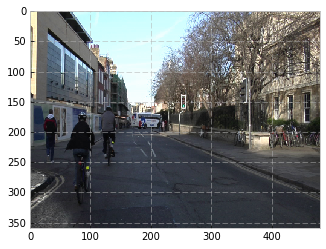

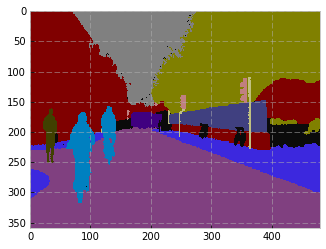

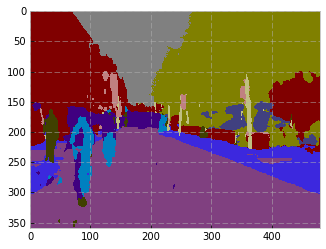

In [34]:
view_sample_predictions(1)

In [35]:
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()
test(model, test_loader, criterion)  # resturn test_loss, test_error

(1.0636298246521807, 21.74139150214592)

In [36]:
def view_sample_predictions(n):
    #torch.cuda.manual_seed(random.randint(0,10**7))
    test_loader = torch.utils.data.DataLoader(test_dset, batch_size=n, shuffle=True)
    inputs, targets = next(iter(test_loader))
    data, label = Variable(inputs.cuda(), volatile=True), Variable(targets.cuda())
    output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(batch_size):
        view_image(inputs[i])
        view_annotated(targets[i])
        view_annotated(pred[i])   

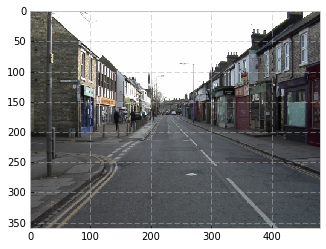

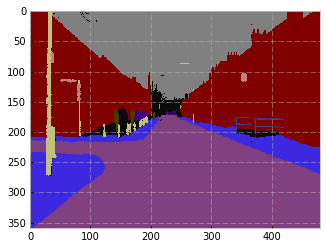

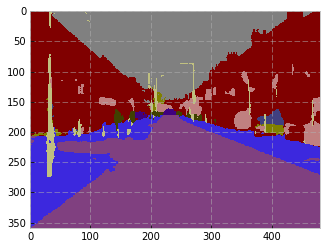

In [51]:
view_sample_predictions(1)